In [102]:
import os
import math
import time
import json
import torch
import matplotlib.pyplot as plt

from torch import nn
from opencc import OpenCC
from torch.autograd import Variable

In [2]:
torch.cuda.is_available()

True

In [3]:
data_path = "./dataset/全唐诗/"

In [4]:
data_dir = os.listdir(data_path)

In [5]:
data_raw = []

for filename in data_dir:
    if not filename.startswith("poet.song."): continue
    content = json.load(open(data_path + filename, encoding="utf-8"))

    for poem in content:
        for line in poem["paragraphs"]:
            # only remain poems with 7 words (七言絕句/律詩).
            if len(line) != 16: break
            data_raw.append(line)

In [6]:
print(f"Total: %d poems." % len(data_raw))

Total: 511460 poems.


In [7]:
data_raw = data_raw[:12000]

In [8]:
# Translate from simplified to traditinal.
cc = OpenCC("s2t")
data_convert = [cc.convert(x) for x in data_raw]

In [9]:
data_split = [list(x) for x in data_convert]

In [10]:
data_split[0]

['欲',
 '出',
 '未',
 '出',
 '光',
 '辣',
 '達',
 '，',
 '千',
 '山',
 '萬',
 '山',
 '如',
 '火',
 '發',
 '。']

In [11]:
word_set = set()

for poem in data_split:
    for word in poem:
        word_set.add(str(word))

In [12]:
word_len = len(word_set)

In [13]:
word_to_index = {x: i for i, x in enumerate(word_set)}
index_to_word = {i: x for i, x in enumerate(word_set)}

In [14]:
train_ds = []

for data in data_split:
    temp = [(data[i:i + 8], data[i + 8]) for i in range(8)]
    train_ds.extend(temp)

In [15]:
train_ds[:8]

[(['欲', '出', '未', '出', '光', '辣', '達', '，'], '千'),
 (['出', '未', '出', '光', '辣', '達', '，', '千'], '山'),
 (['未', '出', '光', '辣', '達', '，', '千', '山'], '萬'),
 (['出', '光', '辣', '達', '，', '千', '山', '萬'], '山'),
 (['光', '辣', '達', '，', '千', '山', '萬', '山'], '如'),
 (['辣', '達', '，', '千', '山', '萬', '山', '如'], '火'),
 (['達', '，', '千', '山', '萬', '山', '如', '火'], '發'),
 (['，', '千', '山', '萬', '山', '如', '火', '發'], '。')]

In [16]:
chunck_len = len(train_ds)

In [17]:
chunck_len

96000

In [18]:
inputs, targets = [], []

for content, target in train_ds:
    content_index = torch.tensor([word_to_index[x] for x in content], dtype=torch.long)
    inputs.append(content_index)

    target_index = torch.tensor([word_to_index[target]], dtype=torch.long)
    targets.append(target_index)

In [19]:
inputs[0], targets[0]

(tensor([2804, 4862,  797, 4862,  485,  802,  903, 1457]), tensor([1001]))

In [20]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size * 8, hidden_size, n_layers, batch_first=True, bidirectional=False)
        self.decoder = nn.Linear(hidden_size, output_size)

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

    def forward(self, input: torch.Tensor, hidden: torch.Tensor):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))

        return output, hidden

In [21]:
# n_epochs = 80
# print_every = 100
# plot_every = 1
# hidden_size = 750
# n_layers = 1
# lr = 0.015

# Dataset: 12000
# Optimizer: Adam
# Loss Function: CrossEntropyLoss

In [22]:
n_epochs = 80
print_every = 100
plot_every = 1
hidden_size = 750
n_layers = 1
lr = 0.015

decoder = RNN(word_len, hidden_size, word_len, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0
decoder.cuda()

RNN(
  (encoder): Embedding(5198, 750)
  (gru): GRU(6000, 750, batch_first=True)
  (decoder): Linear(in_features=750, out_features=5198, bias=True)
)

In [23]:
param = 0

for p in decoder.parameters():
    param += p.numel()

print(param)

22994198


In [24]:
def train(inputs, target):
    hidden = decoder.init_hidden().cuda()
    decoder.zero_grad()
    loss: torch.Tensor = 0
    
    for c in range(chunck_len):
        output, hidden = decoder(inputs[c].cuda(), hidden)
        loss += criterion(output, target[c].cuda())

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunck_len

In [25]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [26]:
for epoch in range(1, n_epochs + 1):
    loss = train(inputs, targets)       
    loss_avg += loss

    print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))

    all_losses.append(loss_avg / plot_every)
    loss_avg = 0

 54s (1 1%) 8.6132]
 48s (2 2%) 8.4691]
 40s (3 3%) 8.0632]
 35s (4 5%) 9.2646]
 28s (5 6%) 9.1008]
 22s (6 7%) 8.7497]
 14s (7 8%) 7.9971]
 5s (8 10%) 7.8436]
 58s (9 11%) 7.7047]
 50s (10 12%) 7.5647]
 41s (11 13%) 7.4474]
 34s (12 15%) 7.2649]
 25s (13 16%) 7.0475]
 17s (14 17%) 6.8422]
 7s (15 18%) 6.7035]
 58s (16 20%) 6.5400]
 49s (17 21%) 6.3914]
 40s (18 22%) 6.2428]
 32s (19 23%) 6.0943]
 23s (20 25%) 5.9569]
 15s (21 26%) 5.8458]
 5s (22 27%) 5.7293]
 57s (23 28%) 5.5628]
 48s (24 30%) 5.4127]
 40s (25 31%) 5.2638]
 31s (26 32%) 5.1430]
 23s (27 33%) 5.0642]
 15s (28 35%) 4.8613]
 7s (29 36%) 4.7138]
 59s (30 37%) 4.5819]
 51s (31 38%) 4.3968]
 43s (32 40%) 4.2321]
 35s (33 41%) 4.0648]
 26s (34 42%) 3.8910]
 19s (35 43%) 3.7174]
 10s (36 45%) 3.5465]
 3s (37 46%) 3.3739]
 55s (38 47%) 3.2006]
 47s (39 48%) 3.0265]
 39s (40 50%) 2.8591]
 30s (41 51%) 2.6979]
 22s (42 52%) 2.5431]
 13s (43 53%) 2.4052]
 6s (44 55%) 2.2863]
 56s (45 56%) 2.1241]
 48s (46 57%) 1.9408]
 41s (47 5

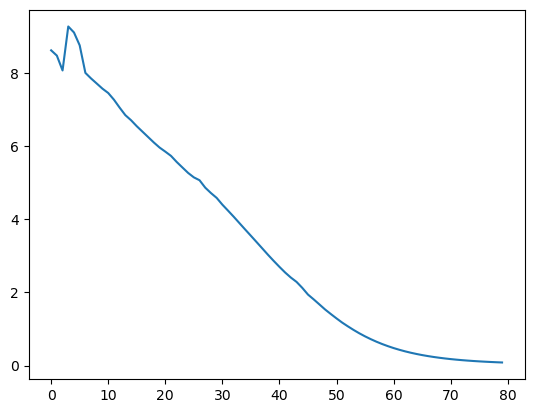

In [27]:
plt.figure()
plt.plot(all_losses)

In [37]:
torch.save(decoder, "./PoemAI_v1_plus.pt")

In [29]:
@torch.no_grad()
def evaluate(prompt: str, predict_len=8, temperature=1):
    hidden = decoder.init_hidden().cuda()

    for p in range(predict_len):
        prompt_input = torch.tensor([word_to_index[x] for x in list(prompt)], dtype=torch.long).cuda()
        inputs = prompt_input[-8:] # Max input size is 7.

        outputs, hidden = decoder(inputs, hidden)

        output_dist = outputs.data.view(-1).div(temperature).exp()
        top = torch.multinomial(output_dist, 1)[0]

        predict_word = index_to_word[int(top)]

        prompt += predict_word

    return prompt

In [101]:
prompt = "鳳凰台上鳳凰遊，"
for _ in range(20):
    output = evaluate(prompt)
    print(output)

鳳凰台上鳳凰遊，遂津樓骨且故峯。
鳳凰台上鳳凰遊，人與星詩上有真。
鳳凰台上鳳凰遊，露燔人間龍二船。
鳳凰台上鳳凰遊，非匣百吟萬士新。
鳳凰台上鳳凰遊，姓蟯原鳳絕柱鳴。
鳳凰台上鳳凰遊，公茲如盤放無流。
鳳凰台上鳳凰遊，鑾踏淫芋人勿爲。
鳳凰台上鳳凰遊，霄是履天不上月。
鳳凰台上鳳凰遊，丹戰人在亦有宗。
鳳凰台上鳳凰遊，四溟休依黃地取。
鳳凰台上鳳凰遊，汾是宗人到尊身。
鳳凰台上鳳凰遊，辰兆公然真恨馬。
鳳凰台上鳳凰遊，變冠英天只與朝。
鳳凰台上鳳凰遊，萬殻瀑炷非生康。
鳳凰台上鳳凰遊，公是樓前亦不歸。
鳳凰台上鳳凰遊，人人塢詩隠世梁。
鳳凰台上鳳凰遊，笙涼眼吟真作壽。
鳳凰台上鳳凰遊，月遷煎頭寒一雲。
鳳凰台上鳳凰遊，顱聞滿軒失九酌。
鳳凰台上鳳凰遊，公氣煩窮葛影處。
